In [1]:
import momepy as mm
import numpy as np
import numba
import geopandas as gpd
import pandas as pd
import shapely
from fast_hdbscan.numba_kdtree import NumbaKDTree, kdtree_to_numba, rdist, point_to_node_lower_bound_rdist
from sklearn.preprocessing import StandardScaler
from collections import namedtuple
from core.cluster_validation import get_linkage_matrix
import umap

In [3]:
regions_datadir = "/data/uscuni-ulce/"
morphotopes_dir = '/data/uscuni-ulce/processed_data/morphotopes/'
model_params = '_100_0_None_None_False'

In [2]:
# %%time

# ### read all morphotopes
# region_hulls = gpd.read_parquet(
#         regions_datadir + "regions/" + "cadastre_regions_hull.parquet"
# )

# data = []
# for region_id, _ in region_hulls.iterrows():
#     region_morphotope_data = pd.read_parquet(f'{morphotopes_dir}data_morphotopes_{region_id}{model_params}.pq')
#     region_morphotope_data.index = str(region_id) + '_' + region_morphotope_data.index.str[:]
#     data.append(region_morphotope_data)

# data = pd.concat(data)

In [4]:
data.shape

NameError: name 'data' is not defined

In [4]:
## read a single region


# model_params = '_100_3__median_gaussian_False'

region_id = 69333
data = pd.read_parquet(f'{morphotopes_dir}data_morphotopes_{region_id}{model_params}.pq')
data.index = str(region_id) + '_' + data.index

In [5]:
### drop noise
data = data[data.index.str[-2:] != '-1']

In [6]:
# data = data.drop(columns=['mibLAL', 'mibCCo'], level=0)

In [7]:
sizes = data.iloc[:, -1]
data = data.iloc[:, :-1]

In [8]:
vals = StandardScaler().fit_transform(data)
component_data = pd.DataFrame(vals, columns=data.columns, index=data.index)
component_data = component_data.drop(component_data.columns[component_data.std() == 0], axis=1)

# component_data = component_data[component_data.index >= 0]
vals = np.nan_to_num(component_data)
component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)


In [9]:
standardised_data = component_data.copy()

In [10]:
sizes.sort_values(ascending=False).describe().iloc[1:]

mean    174.556650
std      74.620971
min     100.000000
25%     120.000000
50%     150.000000
75%     208.000000
max     709.000000
Name: (Size, Size), dtype: float64

In [11]:
# component_data = standardised_data.drop(columns=['percentile_25', 'percentile_75', 'mean'], level=1)

In [12]:
component_data.columns.get_level_values(0).unique()

Index(['sdbAre', 'sdbPer', 'sdbCoA', 'ssbCCo', 'ssbCor', 'ssbSqu', 'ssbERI',
       'ssbElo', 'ssbCCM', 'ssbCCD', 'stbOri', 'mtbSWR', 'libNCo', 'ldbPWL',
       'ltcBuA', 'mtbAli', 'mtbNDi', 'ltbIBD', 'stbCeA', 'stbSAl', 'sdsLen',
       'sssLin', 'ldsMSL', 'ldsRea', 'ldsAre', 'sisBpM', 'sdsSPW', 'sdsSPO',
       'sdsSWD', 'mtdDeg', 'lcdMes', 'linP3W', 'linP4W', 'linPDE', 'lcnClo',
       'lddNDe', 'linWID', 'ldsCDL', 'xcnSCl', 'mtdMDi', 'sddAre', 'midRea',
       'midAre', 'stcOri', 'sdcLAL', 'sdcAre', 'sscCCo', 'sscERI', 'mtcWNe',
       'mdcAre', 'ltcWRB', 'sicCAR', 'stcSAl', 'ldkAre', 'ldkPer', 'lskCCo',
       'lskERI', 'lskCWA', 'ltkOri', 'ltkWNB', 'likWBB', 'sdsAre', 'likWCe',
       'mibCou', 'mibAre', 'mibLen', 'mibElo', 'mibERI', 'mibCCo', 'mibLAL'],
      dtype='object')

In [16]:
%%capture cap

n_neighbors = 25
umap_metric = 'euclidean'

reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=20, 
                    min_dist=0, negative_sample_rate=50, 
                    metric=umap_metric, verbose=True, random_state=1)

embedding = reducer.fit_transform(component_data.values)


## save the data for later
import joblib
filename = f'../data/umap_morphotopes_model_{n_neighbors}.sav'
joblib.dump(reducer, filename)
pd.DataFrame(embedding, index=data.index).to_parquet(f'../data/umap_embedding_{n_neighbors}.pq')

In [12]:
# %%capture cap

n_neighbors = 10
umap_metric = 'euclidean'

reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=20, 
                    min_dist=0, negative_sample_rate=50, 
                    metric=umap_metric, verbose=True, random_state=1)

embedding = reducer.fit_transform(component_data.values)

# ## save the data for later
# import joblib
# filename = f'../data/umap_morphotopes_model_{n_neighbors}.sav'
# joblib.dump(reducer, filename)
# pd.DataFrame(embedding, index=data.index).to_parquet(f'../data/umap_embedding_{n_neighbors}.pq')

/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(min_dist=0, n_components=20, n_jobs=1, n_neighbors=10, negative_sample_rate=50, random_state=1, verbose=True)
Fri Oct 18 09:59:19 2024 Construct fuzzy simplicial set
Fri Oct 18 09:59:20 2024 Finding Nearest Neighbors
Fri Oct 18 09:59:21 2024 Finished Nearest Neighbor Search
Fri Oct 18 09:59:22 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Fri Oct 18 09:59:39 2024 Finished embedding


In [18]:
cap.show()

UMAP(min_dist=0, n_components=20, n_jobs=1, n_neighbors=25, negative_sample_rate=50, random_state=1, verbose=True)
Tue Oct 15 19:37:45 2024 Construct fuzzy simplicial set
Tue Oct 15 19:37:46 2024 Finding Nearest Neighbors
Tue Oct 15 19:37:46 2024 Building RP forest with 58 trees
Tue Oct 15 19:38:57 2024 NN descent for 20 iterations
	 1  /  20
	 2  /  20
	 3  /  20
	 4  /  20
	Stopping threshold met -- exiting after 4 iterations
Tue Oct 15 19:41:17 2024 Finished Nearest Neighbor Search
Tue Oct 15 19:41:23 2024 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Tue Oct 15 22:55:43 2024 Finished embedding
Tue Oct 15 22:56:52 2024 Worst tree score: 0.44794830
Tue Oct 15 22:56:52 2024 Mean tree score: 0.45706307
Tue Oct 15

/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Epochs completed:   0%|            0/200 [00:00]

In [13]:
component_data = pd.DataFrame(embedding)

In [16]:
# n_neighbors = 25
# component_data = pd.read_parquet(f'../data/umap_embedding_{n_neighbors}.pq')

In [17]:
# component_data  = standardised_data

In [18]:
# component_data = component_data.loc[:, component_data.columns[np.arange(1, data.shape[1], 3)]]

In [19]:
# min_cluster_size = 5_000
# sample_weights = sizes.values.astype(np.float32)
# sample_weights[sample_weights > min_cluster_size] = int(min_cluster_size / n_neighbors)

# # min_cluster_size = 50
# # sample_weights = np.ones(sizes.shape[0]).astype(np.float32)

# allow_single_cluster = False

### weighted hsbcan

In [13]:
from fast_hdbscan.boruvka import parallel_boruvka
from fast_hdbscan.cluster_trees import (mst_to_linkage_tree_w_sample_weights, 
condense_tree, cluster_tree_from_condensed_tree, extract_eom_clusters,
get_cluster_label_vector, bfs_from_hierarchy, eliminate_branch, CondensedTree, score_condensed_tree_nodes, eom_recursion)
from sklearn.neighbors import KDTree

In [83]:
# from fast_hdbscan import fast_hdbscan
# res = fast_hdbscan(component_data.values, sample_weights=sample_weights.astype(np.float32), min_samples=min_cluster_size, min_cluster_size=min_cluster_size , return_trees=True)

In [84]:
# min_samples = 10

min_samples = min_cluster_size

In [45]:
%%time

## hdbscan kdtree
sklearn_tree = KDTree(component_data.values)
numba_tree = kdtree_to_numba(sklearn_tree)

edges = parallel_boruvka(
    numba_tree,
    min_samples=min_samples,
    sample_weights=sample_weights,
)
sorted_mst = edges[np.argsort(edges.T[2])]

linkage_tree = mst_to_linkage_tree_w_sample_weights(sorted_mst, sample_weights)

CPU times: user 9min 28s, sys: 634 ms, total: 9min 28s
Wall time: 33.2 s


In [16]:
### agglomerative clustering tree
def get_linkage_matrix_sizes(model, sizes=None):
    """" Create a linkage matrix from a sklearn hierarchical clustering model.
    Requires the full tree and the distances stored in the model instance.
    If sizes is None, by default every sample has weight 1"""

    if sizes is None:
        sizes = np.ones(model.labels_.shape[0])
    
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += sizes[child_idx]  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    return linkage_matrix

In [81]:
# ### agglomerative clustering tree

# linkage = 'ward'
# metric = 'euclidean'
# sklearn_linkage_structure = namedtuple('Model', ['children_', 'labels_', 'distances_'])


# from sklearn.cluster import AgglomerativeClustering
# clusterer = AgglomerativeClustering(linkage=linkage,
#                                     metric=metric,
#                                     compute_full_tree=True,
#                                     compute_distances=True)
# model = clusterer.fit(component_data.values[sizes > 100])
# linkage_tree = get_linkage_matrix_sizes(model, sizes=None)

In [48]:
### tests against hdbscan linkage tree

# m = sklearn_linkage_structure(linkage_tree[:, [0, 1]].astype(int),
#                               np.ones(component_data.shape[0]),
#                               linkage_tree[:, 2])

# l = get_linkage_matrix_sizes(m, sizes=sample_weights)
# assert np.allclose(l, linkage_tree)

# l1 = get_linkage_matrix(model)
# l2 = get_linkage_matrix_sizes(model)
# assert np.allclose(l1, l2)

In [49]:
# min_cluster_size = 250_000

In [50]:
@numba.njit(fastmath=True)
def condense_tree(hierarchy, min_cluster_size=10, bandwidth=1, sample_weights=None):
    root = 2 * hierarchy.shape[0]
    num_points = hierarchy.shape[0] + 1
    next_label = num_points + 1

    node_list = bfs_from_hierarchy(hierarchy, root, num_points)

    relabel = np.zeros(root + 1, dtype=np.int64)
    relabel[root] = num_points

    parents = np.ones(root, dtype=np.int64)
    children = np.empty(root, dtype=np.int64)
    lambdas = np.empty(root, dtype=np.float32)
    sizes = np.ones(root, dtype=np.int64)

    ignore = np.zeros(root + 1, dtype=np.bool_) # 'bool' is no longer an attribute of 'numpy'

    if sample_weights is None:
        sample_weights = np.ones(num_points, dtype=np.float32)

    idx = 0

    for node in node_list:
        if ignore[node] or node < num_points:
            continue

        parent_node = relabel[node]
        l, r, d, _ = hierarchy[node - num_points]
        left = np.int64(l)
        right = np.int64(r)
        if d > 0.0:
            # gaussian lambda value
            # lambda_value = np.exp(-(((d / bandwidth) / 2) ** 2)) / (np.sqrt(2) * np.pi)
            lambda_value = 1.0 / d
        else:
            lambda_value = np.inf

        left_count = np.int64(hierarchy[left - num_points, 3]) if left >= num_points else sample_weights[left]
        right_count = np.int64(hierarchy[right - num_points, 3]) if right >= num_points else sample_weights[right]

        # The logic here is in a strange order, but it has non-trivial performance gains ...
        # The most common case by far is a singleton on the left; and cluster on the right take care of this separately
        if left < num_points and right_count >= min_cluster_size:
            relabel[right] = parent_node
            parents[idx] = parent_node
            children[idx] = left
            lambdas[idx] = lambda_value
            idx += 1
        # Next most common is a small left cluster and a large right cluster: relabel the right node; eliminate the left branch
        elif left_count < min_cluster_size and right_count >= min_cluster_size:
            relabel[right] = parent_node
            idx = eliminate_branch(left, parent_node, lambda_value, parents, children, lambdas, sizes, idx, ignore,
                                   hierarchy, num_points)
        # Then we have a large left cluster and a small right cluster: relabel the left node; elimiate the right branch
        elif left_count >= min_cluster_size and right_count < min_cluster_size:
            relabel[left] = parent_node
            idx = eliminate_branch(right, parent_node, lambda_value, parents, children, lambdas, sizes, idx, ignore,
                                   hierarchy, num_points)
        # If both clusters are small then eliminate all branches
        elif left_count < min_cluster_size and right_count < min_cluster_size:
            idx = eliminate_branch(left, parent_node, lambda_value, parents, children, lambdas, sizes, idx, ignore,
                                   hierarchy, num_points)
            idx = eliminate_branch(right, parent_node, lambda_value, parents, children, lambdas, sizes, idx, ignore,
                                   hierarchy, num_points)
        # and finally if we actually have a legitimate cluster split, handle that correctly
        else:
            relabel[left] = next_label

            parents[idx] = parent_node
            children[idx] = next_label
            lambdas[idx] = lambda_value
            sizes[idx] = left_count
            next_label += 1
            idx += 1

            relabel[right] = next_label

            parents[idx] = parent_node
            children[idx] = next_label
            lambdas[idx] = lambda_value
            sizes[idx] = right_count
            next_label += 1
            idx += 1

    return CondensedTree(parents[:idx], children[:idx], lambdas[:idx], sizes[:idx])

In [51]:
from scipy.stats import gaussian_kde
e = gaussian_kde(sorted_mst[:, 2])
f = e.covariance_factor()
bw = f * linkage_tree[:, 2].std()
bw

np.float64(0.009027899389063818)

In [52]:
condensed_tree = condense_tree(linkage_tree, 
                               min_cluster_size=min_cluster_size,
                               bandwidth=.02,
                               sample_weights=sample_weights)

In [53]:
cluster_tree = cluster_tree_from_condensed_tree(condensed_tree)

In [54]:
@numba.njit()
def score_condensed_tree_nodes(condensed_tree):
    result = {0: np.float64(0.0) for i in range(0)}

    for i in range(condensed_tree.parent.shape[0]):
        parent = condensed_tree.parent[i]
        if parent in result:
            result[parent] += condensed_tree.lambda_val[i] * condensed_tree.child_size[i]
        else:
            result[parent] = condensed_tree.lambda_val[i] * condensed_tree.child_size[i]

        if condensed_tree.child_size[i] > 1:
            child = condensed_tree.child[i]
            if child in result:
                result[child] -= condensed_tree.lambda_val[i] * condensed_tree.child_size[i]
            else:
                result[child] = -condensed_tree.lambda_val[i] * condensed_tree.child_size[i]

    return result

@numba.njit()
def extract_eom_clusters(condensed_tree, cluster_tree, allow_single_cluster=False):
    node_scores = score_condensed_tree_nodes(condensed_tree)
    selected_clusters = {node: False for node in node_scores}

    if len(cluster_tree.parent) == 0:
        return np.zeros(0, dtype=np.int64)

    cluster_tree_root = cluster_tree.parent.min()

    if allow_single_cluster:
        eom_recursion(cluster_tree_root, cluster_tree, node_scores, selected_clusters)
    elif len(node_scores) > 1:
        root_children = cluster_tree.child[cluster_tree.parent == cluster_tree_root]
        for child_node in root_children:
            eom_recursion(child_node, cluster_tree, node_scores, selected_clusters)

    return np.asarray([node for node, selected in selected_clusters.items() if selected])

In [55]:
selected_clusters = extract_eom_clusters(condensed_tree, cluster_tree, allow_single_cluster=allow_single_cluster)

In [56]:
# from fast_hdbscan.cluster_trees import extract_leaves
# selected_clusters = extract_leaves(
#             condensed_tree, allow_single_cluster=False
# )

In [57]:
clusters = get_cluster_label_vector(
        condensed_tree,
        selected_clusters,
        0,
        n_samples=data.shape[0],
    )
pd.Series(clusters).value_counts()

 28    502552
 29    261012
 21    112475
 24    110228
 23     42909
 26     39380
 27     15145
 11     12965
 16      7699
 3       6069
 8       5099
 25      4965
 10      4112
 15      3207
 9       2498
 18      2100
 17      1126
 6        465
 4        406
 19       211
 12       194
 1        175
 14       168
 20       150
-1        122
 13        94
 22        85
 2         76
 7         60
 5         57
 0         57
Name: count, dtype: int64

In [58]:
pd.Series(linkage_tree[:, 2]).describe().iloc[1:]

mean     0.531443
std      0.146775
min      0.023269
25%      0.453193
50%      0.533837
75%      0.606297
max     22.417928
dtype: float64

In [59]:
# from fast_hdbscan.cluster_trees import get_cluster_labelling_at_cut
# clusters = get_cluster_labelling_at_cut(linkage_tree, .5, 100)
# pd.Series(clusters).value_counts()

## Kmeans

In [13]:
# cols = standardised_data.columns.get_level_values(0).unique()
# to_drop = cols[~cols.str.startswith('s')][:-3]
# component_data = standardised_data.drop(columns=to_drop, level=0)

In [14]:
component_data = standardised_data.drop(columns=['percentile_25', 'percentile_75', 'mean'], level=1)

# component_data = standardised_data

In [16]:
%%time
from sklearn.cluster import KMeans, MiniBatchKMeans
kmeans_clusterer = KMeans(n_clusters=50, random_state=123)
kmeans_clusters = kmeans_clusterer.fit(component_data).labels_
kmeans_cluster_sizes = sizes.groupby(kmeans_clusters).sum().sort_index()

CPU times: user 134 ms, sys: 5.07 ms, total: 139 ms
Wall time: 54.5 ms


In [17]:
pd.Series(kmeans_clusters).value_counts().describe()

count     50.000000
mean      40.600000
std       35.504527
min        1.000000
25%        9.750000
50%       30.500000
75%       68.250000
max      136.000000
Name: count, dtype: float64

In [18]:
kmeans_cluster_sizes.describe()

count       50.000000
mean      7087.000000
std       6144.138866
min        107.000000
25%       1945.000000
50%       5344.000000
75%      11443.000000
max      19341.000000
Name: (Size, Size), dtype: float64

In [19]:

linkage = 'ward'
metric = 'euclidean'
sklearn_linkage_structure = namedtuple('Model', ['children_', 'labels_', 'distances_'])


from sklearn.cluster import AgglomerativeClustering
from core.cluster_validation import get_linkage_matrix
clusterer = AgglomerativeClustering(linkage=linkage,
                                    metric=metric,
                                    compute_full_tree=True,
                                    compute_distances=True)
model = clusterer.fit(kmeans_clusterer.cluster_centers_)
linkage_matrix = get_linkage_matrix(model)

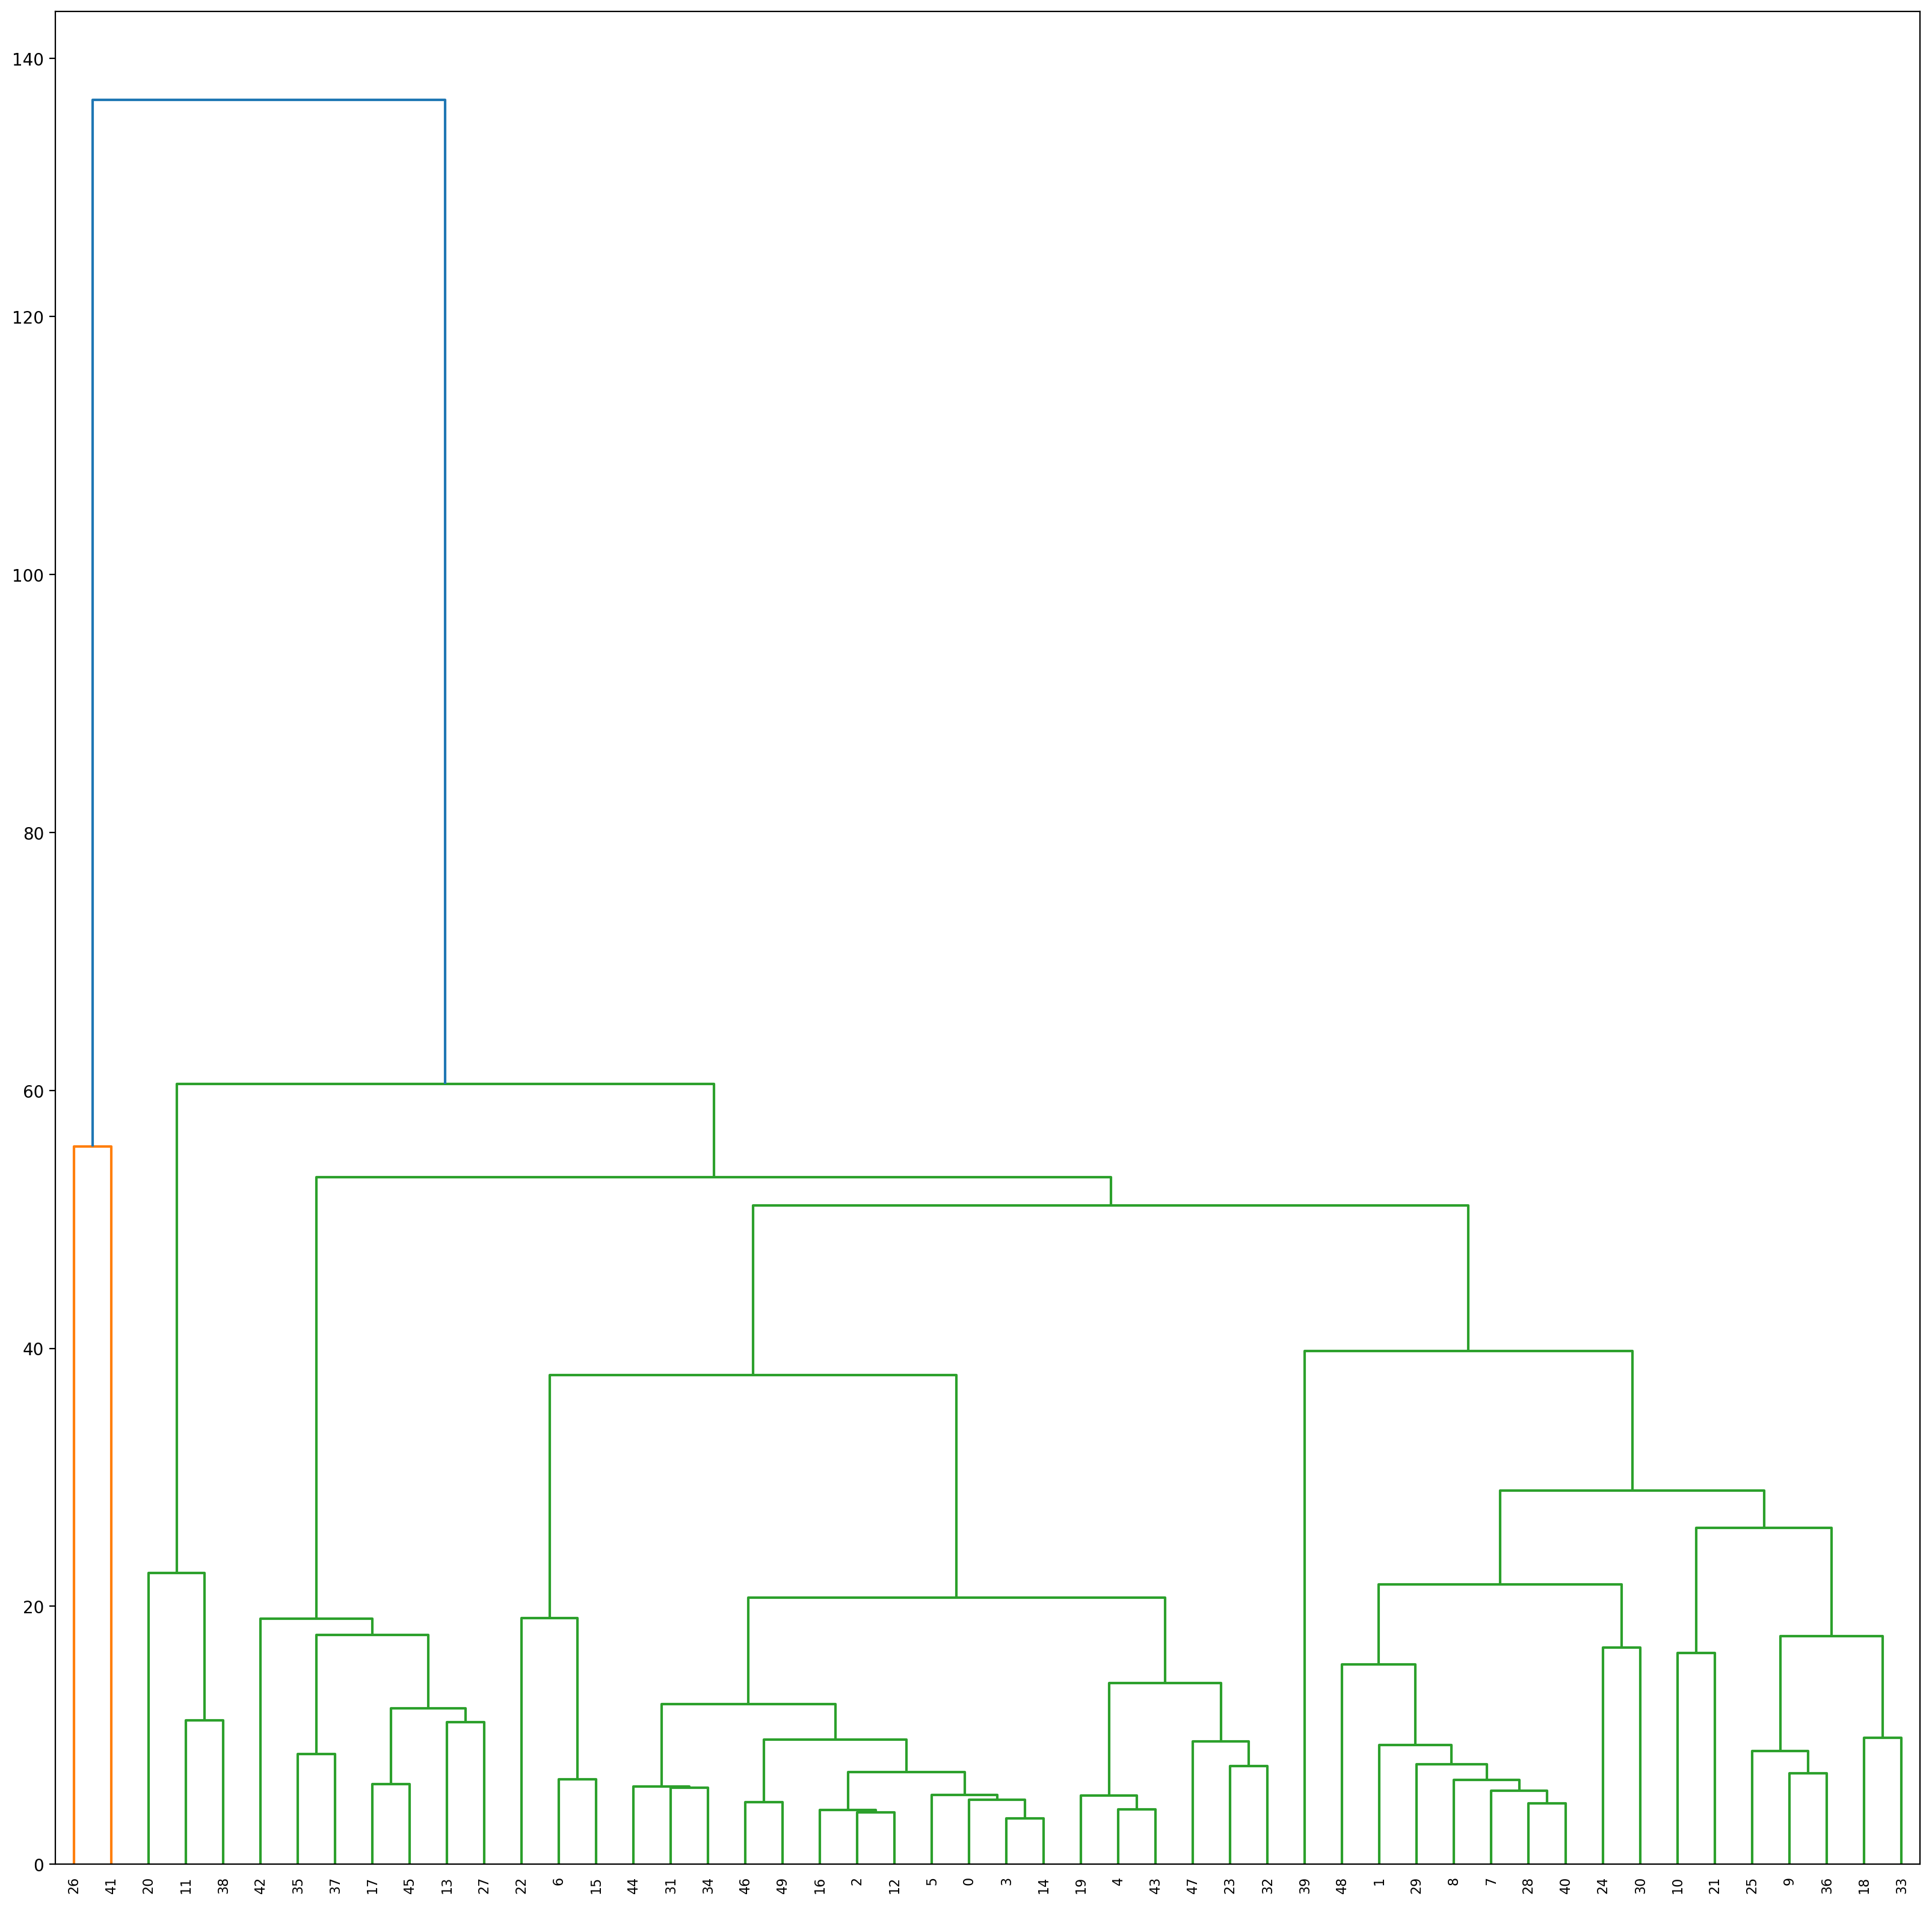

In [20]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, fcluster
from hdbscan.plots import SingleLinkageTree

fig,ax = plt.subplots(figsize=(20,20), dpi=200)
_ = dendrogram(linkage_matrix, ax=ax)

# fig, ax = plt.subplots(figsize=(20,10))
# SingleLinkageTree(linkage_matrix).plot(axis=ax)

In [113]:
cutoff = 7

In [114]:
ward_clusters = fcluster(linkage_matrix, t=cutoff, criterion='distance')
ward_clusters = pd.Series(ward_clusters, index=np.arange(np.unique(kmeans_clusters).shape[0]))
np.unique(ward_clusters)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25], dtype=int32)

In [115]:
clusters = pd.Series(kmeans_clusters).map(lambda x: ward_clusters.loc[x]).values

In [21]:
clusters = kmeans_clusters.copy()

In [22]:
region_id = 69333



etcs = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/tessellations/tessellation_{region_id}.parquet')
etcs['label'] = -1

morphotopes = pd.read_parquet(f'/data/uscuni-ulce/processed_data/morphotopes/tessellation_labels_morphotopes_{region_id}{model_params}.pq')
morphotopes.loc[:, 'morphotope_label'] =  morphotopes.values[:, 0]

region_clusters = pd.Series(clusters, data.index)[data.index.str.startswith(str(region_id))]
region_clusters.index = region_clusters.index.str.slice(len(str(region_id)) + 1, )
region_clusters

1005_0     7
1016_0    40
1016_1    12
1016_2    12
1018_0    48
          ..
978_0      5
979_0      8
991_0      5
997_0     40
9_0       40
Length: 2030, dtype: int32

In [23]:
region_clusters.nunique()

50

In [24]:
region_clusters.value_counts()

40    136
12    117
14    108
4     103
34     96
3      90
5      88
43     83
28     77
19     73
16     73
49     73
7      69
2      66
31     55
36     53
32     51
8      51
0      46
46     42
44     39
9      36
15     34
1      31
25     31
17     30
6      30
47     28
45     26
23     21
10     19
29     19
13     19
33     15
18     15
24     13
38     12
42      9
22      8
21      8
37      6
11      6
48      5
30      5
27      5
35      5
20      2
39      1
41      1
26      1
Name: count, dtype: int64

In [25]:
%%time
## assign morphotope clusters to tess cells

etcs.loc[morphotopes.index, 'label'] = morphotopes.morphotope_label.map(lambda x: region_clusters.loc[x] if x in region_clusters.index else -1).values


# # # relabel morphotopes for plotting
# morph_dict = pd.Series(np.arange(np.unique(morphotopes.values).shape[0]),
#                        np.unique(morphotopes.values))
# etcs.loc[morphotopes.index, 'label'] = morphotopes.map(lambda x: morph_dict.loc[x]).values

CPU times: user 1.15 s, sys: 59.9 ms, total: 1.21 s
Wall time: 1.16 s


In [26]:
etcs.label.value_counts()

label
-1     107000
 12     19341
 34     19019
 14     18628
 4      18472
 40     17593
 3      17336
 5      16762
 16     15163
 28     14891
 43     14018
 2      13746
 19     13599
 49     11612
 31     10936
 32      8856
 0       8570
 7       8391
 36      8231
 8       8157
 46      7327
 44      6546
 17      6248
 1       5816
 15      5770
 6       5598
 9       5090
 45      5018
 47      4987
 25      4900
 10      3942
 23      3397
 24      3199
 13      2704
 29      2509
 18      2266
 33      2106
 38      1993
 22      1929
 42      1624
 21      1387
 11      1254
 37      1039
 48       956
 30       953
 27       924
 35       870
 20       316
 41       142
 39       112
 26       107
Name: count, dtype: int64

In [129]:
layer.get_fill_color = get_color(etcs.label)

In [48]:
%%time
import lonboard
# plotting = tessellation[tessellation.index.isin(X_train.index)].copy()
layer = lonboard.SolidPolygonLayer.from_geopandas(etcs, opacity=.08)

/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


CPU times: user 7.07 s, sys: 352 ms, total: 7.43 s
Wall time: 7.42 s


In [49]:
from sidecar import Sidecar
sc = Sidecar(title='Final Clusters')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.Positron)
with sc:
    display(m)

In [50]:
from core.cluster_validation import get_color
layer.get_fill_color = get_color(etcs.label)

In [32]:
# why are random vilages in poland closer to vinohrady than vienna's centra stuff ?
# vienna has a similar issue ?
# why is the cluster around pikovice such an outlier ?

In [37]:
target_cluster = 35
etcs[etcs.label == target_cluster].shape

(870, 3)

In [38]:

etcs[etcs.label == target_cluster].explore()

In [70]:
# only_medians = standardised_data.loc[:, data.columns[np.arange(1, data.shape[1], 3)]]

In [63]:
x = standardised_data[clusters == 41].mean() # josefov
y = standardised_data[clusters == 14].mean() # vinohrady
z = standardised_data[clusters == 21].mean() # some other houses

In [64]:
np.sqrt(((x - y)**2).sum()), np.sqrt(((y - z)**2).sum())

(np.float64(17.770870425197096), np.float64(22.17258433568605))

In [65]:
(x - y).abs().sort_values(ascending=False).iloc[:10]

ssbCCD  percentile_10    7.601026
ssbSqu  median           7.073115
ssbCor  percentile_10    6.417903
ssbSqu  percentile_10    4.597933
linP4W  percentile_10    2.607981
linP3W  percentile_90    2.548520
xcnSCl  percentile_10    2.512900
linP3W  median           2.465891
ssbCor  percentile_90    2.426292
stcOri  percentile_90    2.399407
dtype: float64

In [66]:
(y - z).abs().sort_values(ascending=False).iloc[:10]

ssbSqu  median           6.750697
ssbCCD  percentile_10    6.524534
ssbCor  percentile_10    6.223421
ssbERI  percentile_90    4.502626
ltcBuA  percentile_90    4.310105
likWBB  percentile_10    4.017553
sicCAR  percentile_10    3.914716
ltcBuA  median           3.847794
mtbSWR  percentile_10    3.431289
likWBB  median           3.320817
dtype: float64

In [71]:
x = component_data[clusters == 41].mean() # josefov
y = component_data[clusters == 14].mean() # vinohrady
z = component_data[clusters == 21].mean() # some other houses

np.sqrt(((x - y)**2).sum()), np.sqrt(((y - z)**2).sum())

(np.float64(9.935617577498927), np.float64(12.68823610143762))

In [72]:
(x - y).abs().sort_values(ascending=False).iloc[:10]

ssbSqu  median    7.073115
linP3W  median    2.465891
linP4W  median    2.392785
xcnSCl  median    1.823478
ssbCCD  median    1.767985
ssbCor  median    1.554885
mtdDeg  median    1.542368
sdbAre  median    1.405892
sdbPer  median    1.405116
ssbCCo  median    1.391337
dtype: float64

In [73]:
(y - z).abs().sort_values(ascending=False).iloc[:10]

ssbSqu  median    6.750697
ltcBuA  median    3.847794
likWBB  median    3.320817
sicCAR  median    3.245351
ssbCor  median    3.023765
mtbSWR  median    2.778636
linP4W  median    2.450122
ldbPWL  median    2.288683
linP3W  median    2.154971
sdsSPO  median    2.094507
dtype: float64

In [68]:
x = only_medians[clusters == 15].mean() # prague centre
y = only_medians[clusters == 8].mean() # vinohrady
z = only_medians[clusters == 6].mean() # polish town stuff - houses

np.sqrt(((x - y)**2).sum()), np.sqrt(((y - z)**2).sum())

NameError: name 'only_medians' is not defined

### Tree plotting

In [129]:
ct = condensed_tree

In [130]:
ct_raw = np.rec.fromarrays((ct[0], ct[1], ct[2], ct[3]),
         dtype=[('parent', np.intp),('child', np.intp),('lambda_val', float),('child_size', np.intp)])

In [540]:
from hdbscan.plots import CondensedTree
import matplotlib.pyplot as plt

In [541]:
# fig,ax = plt.subplots(figsize=(20,10))
# CondensedTree(ct_raw).plot(colorbar=False)

<Axes: ylabel='distance'>

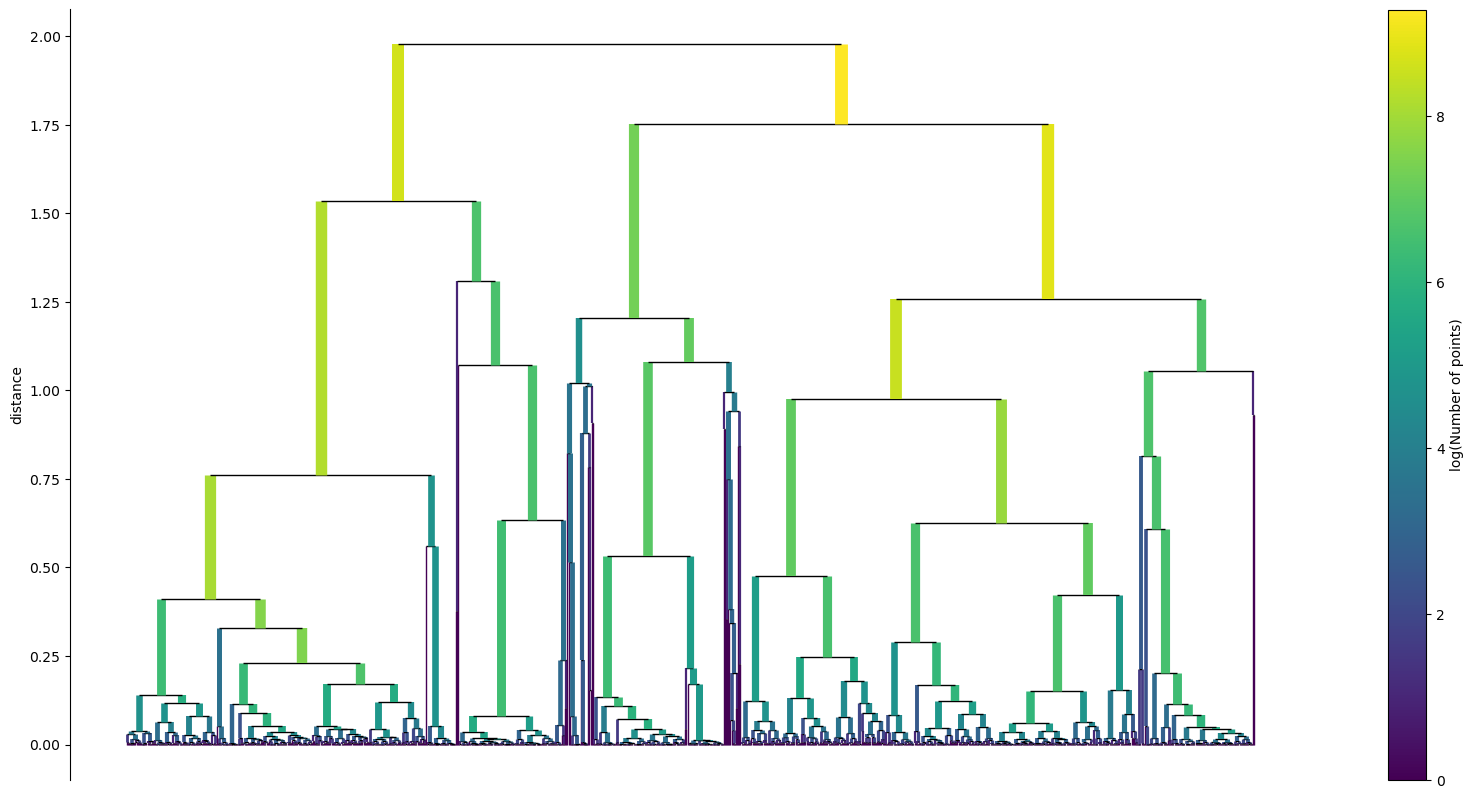

In [543]:
from hdbscan.plots import SingleLinkageTree
fig, ax = plt.subplots(figsize=(20,10))
SingleLinkageTree(linkage_matrix).plot(axis=ax)

In [123]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca_reducer = PCA(n_components=3)
pca_embedding = pca_reducer.fit_transform(component_data)

/tmp/ipykernel_2911159/3759342808.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


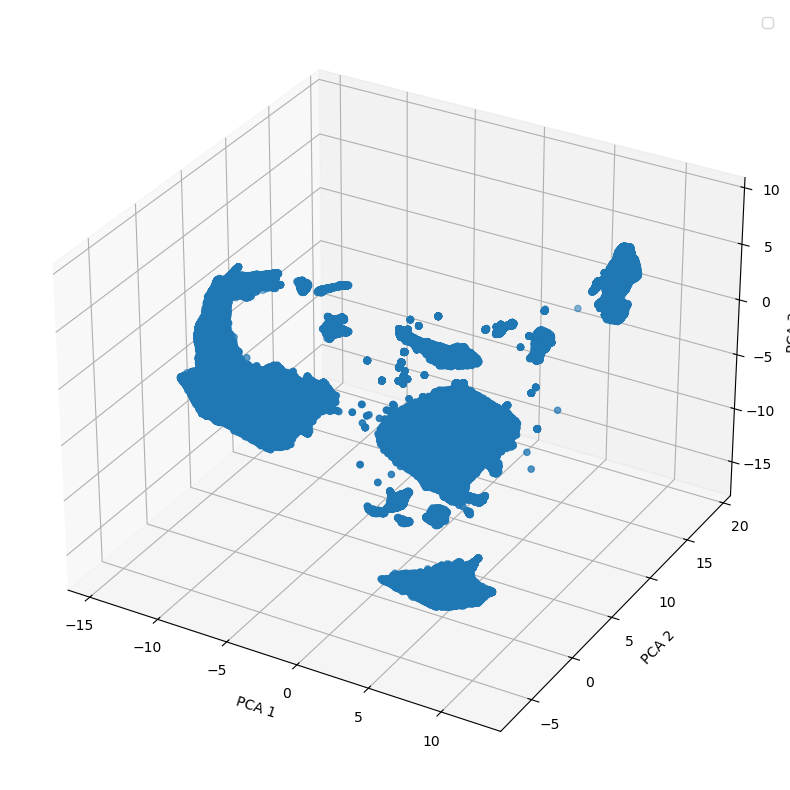

In [124]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(pca_embedding[:, 0], pca_embedding[:, 1], pca_embedding[:, 2])
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
ax.legend()

Text(0.5, 0, 'UMAP 3')

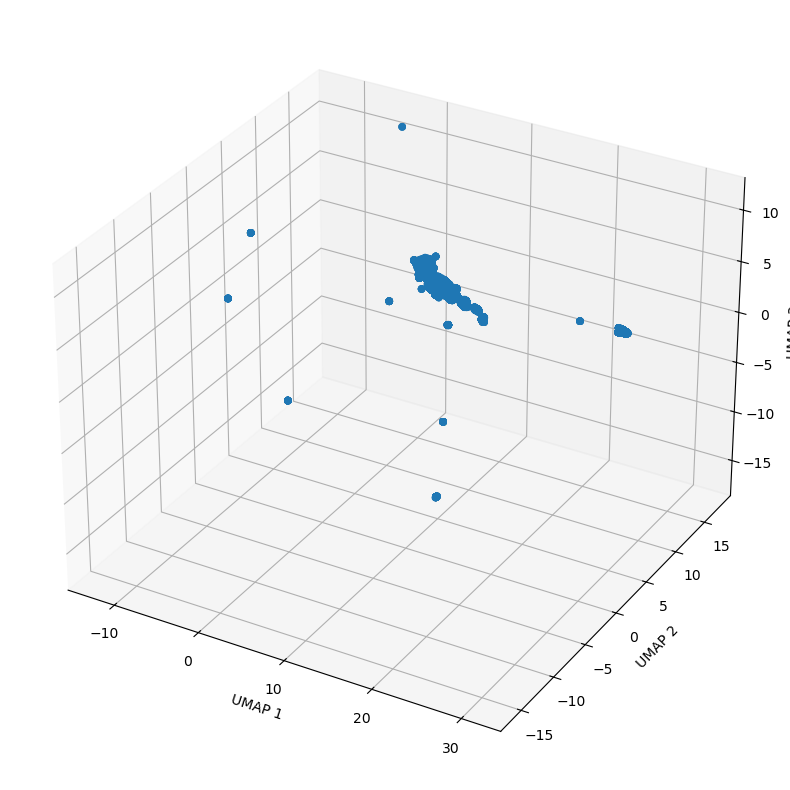

In [125]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2])
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_zlabel("UMAP 3")

In [547]:
plotting_data = component_data.sample(100_000)

In [602]:
europe = gpd.read_file('../data/Europe.zip').to_crs(epsg=3035)
region_hulls['country'] = 'None'

In [607]:
inpt, tree = region_hulls.sindex.query(europe.geometry, predicate='covers')
region_hulls.iloc[tree, -1] = europe.iloc[inpt, 0]
plotting_labels = region_hulls.loc[plotting_data.index.str.split('_').str[0].astype(int), 'country']

In [609]:
plotting_labels.unique()

array(['None', 'DEU', 'CZE', 'POL', 'SVK'], dtype=object)

UMAP(n_neighbors=10, verbose=True)
Wed Oct 16 14:31:34 2024 Construct fuzzy simplicial set
Wed Oct 16 14:31:34 2024 Finding Nearest Neighbors
Wed Oct 16 14:31:34 2024 Building RP forest with 21 trees
Wed Oct 16 14:31:35 2024 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	Stopping threshold met -- exiting after 2 iterations
Wed Oct 16 14:31:39 2024 Finished Nearest Neighbor Search
Wed Oct 16 14:31:40 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Wed Oct 16 14:32:03 2024 Finished embedding


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc 

CPU times: user 6min 30s, sys: 9.04 s, total: 6min 39s
Wall time: 31.9 s


<Axes: >

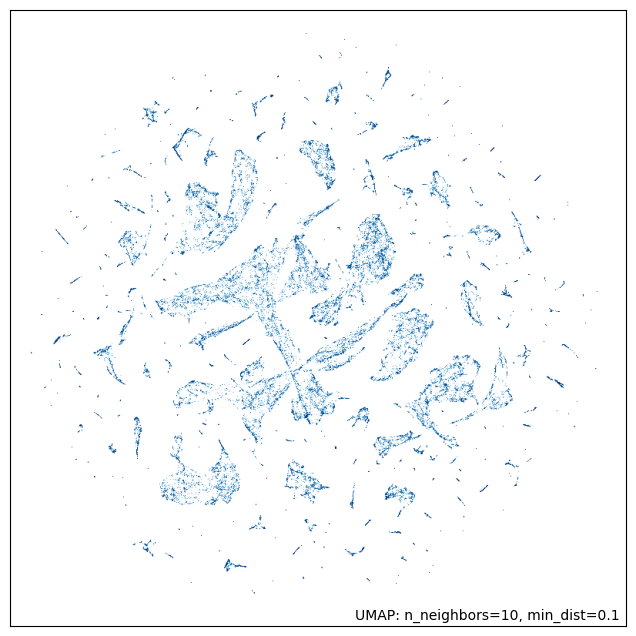

In [597]:
%%time
n_neighbors = 10
umap_metric = 'euclidean'

reducer = umap.UMAP(n_neighbors=10, n_components=2, metric=umap_metric, verbose=True)
embedding = reducer.fit_transform(component_data.sample(100_000))


<Axes: >

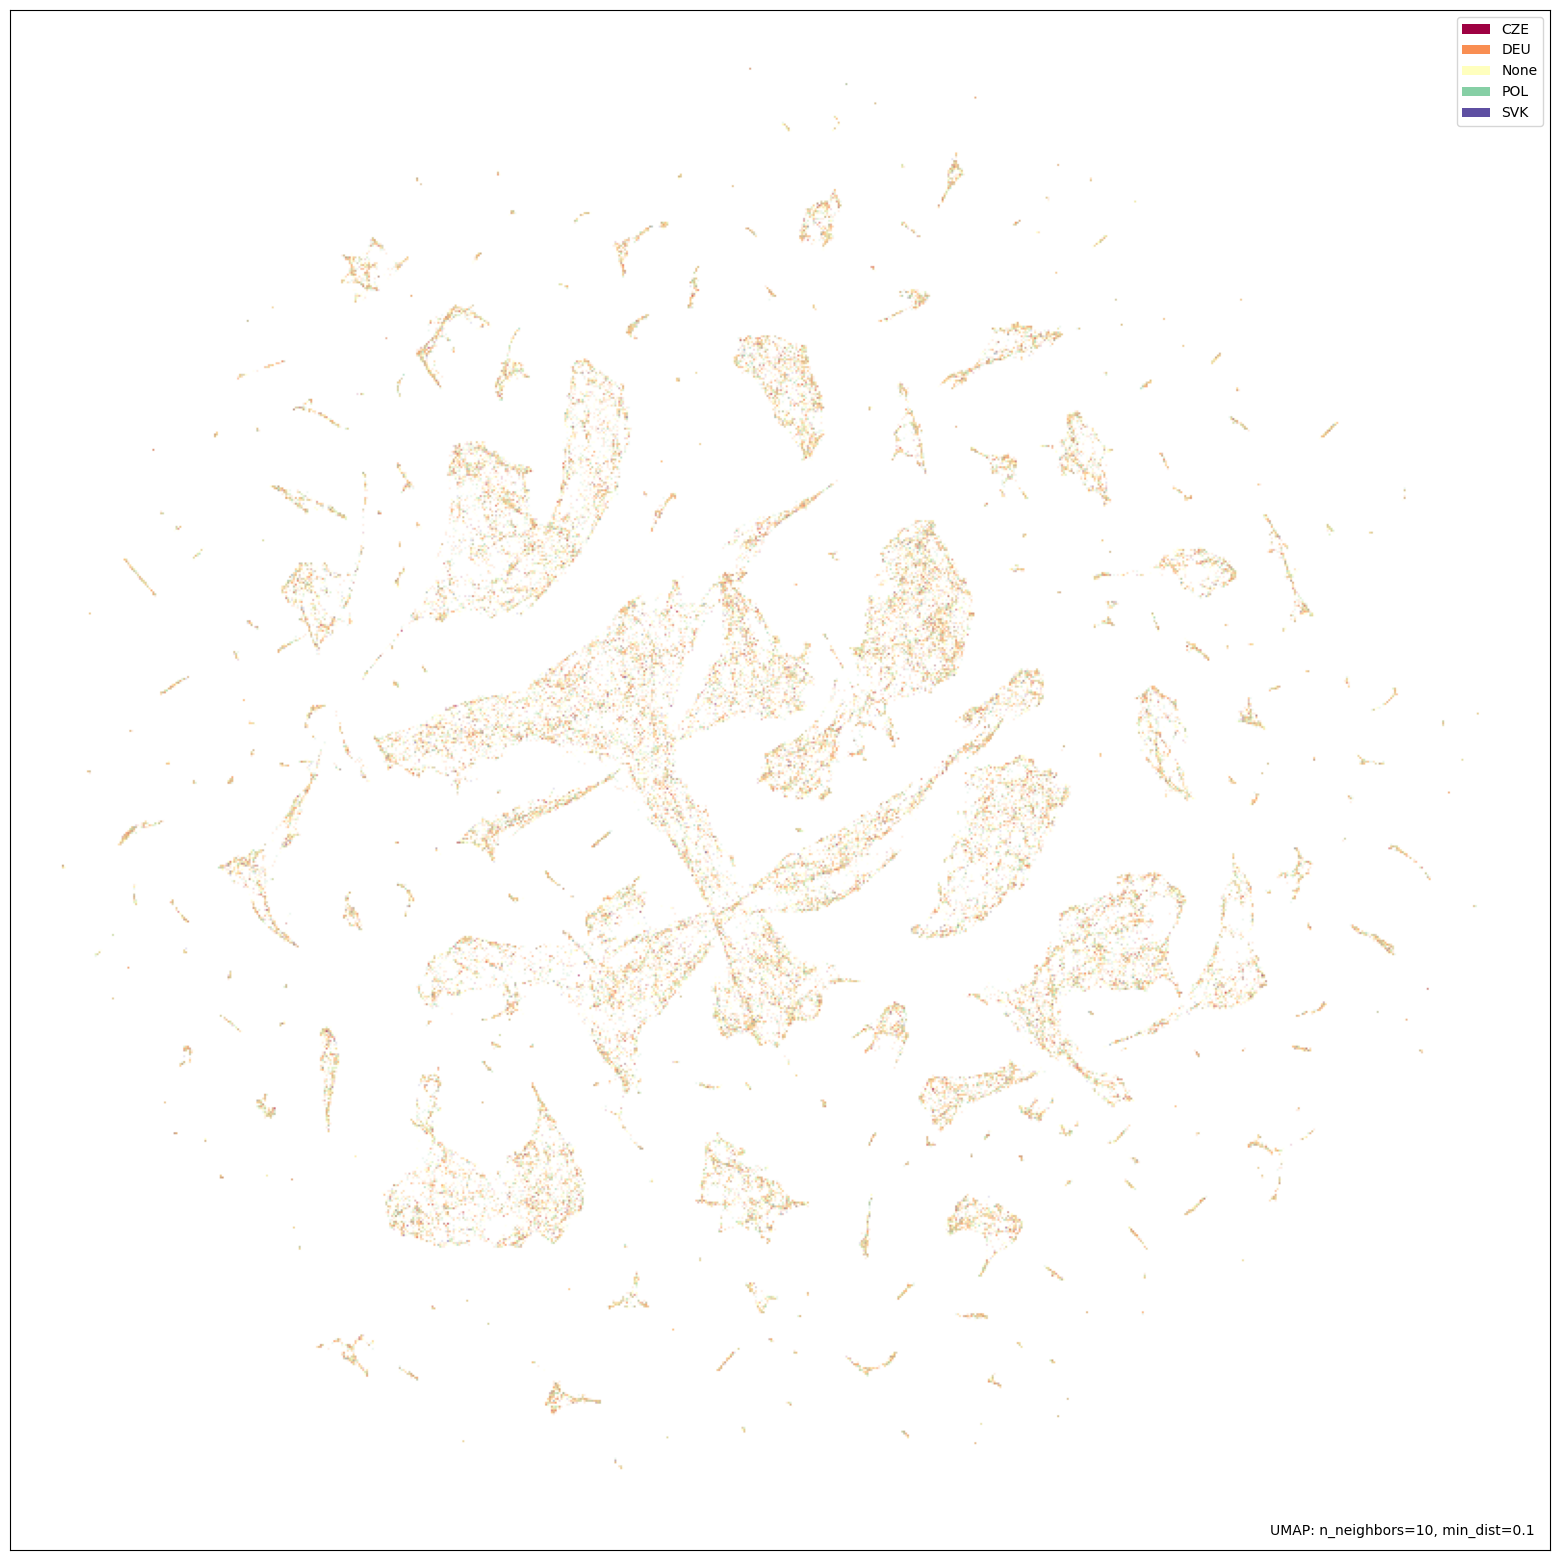

In [610]:
import umap.plot
fig, ax = plt.subplots(figsize=(20,20))
umap.plot.points(reducer, labels=plotting_labels, ax=ax)